<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/Compare%20PID%20and%20Fuzzy%20with%20stochastic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple fuzzy PID controller


@misc{nassim2021speedcontroldcmotor,
      title={Speed Control of DC Motor Using Fuzzy PID Controller},
      author={Messaadi Nassim and Amroun Abdelkader},
      year={2021},
      eprint={2108.05450},
      archivePrefix={arXiv},
      primaryClass={eess.SY},
      url={https://arxiv.org/abs/2108.05450},
}

Original Plant: num=[[1.0]], den=[[2.0, 3.0, 1.0]]
Discretized Plant Numerator (b): [2.48753638e-05 2.47512974e-05]
Discretized Plant Denominator (a): [ 1.         -1.98506231  0.98511194]
Starting Simulation...
Simulation Complete.


/tmp/ipython-input-2864166157.py:412: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[4].twinx().legend(loc='upper right')


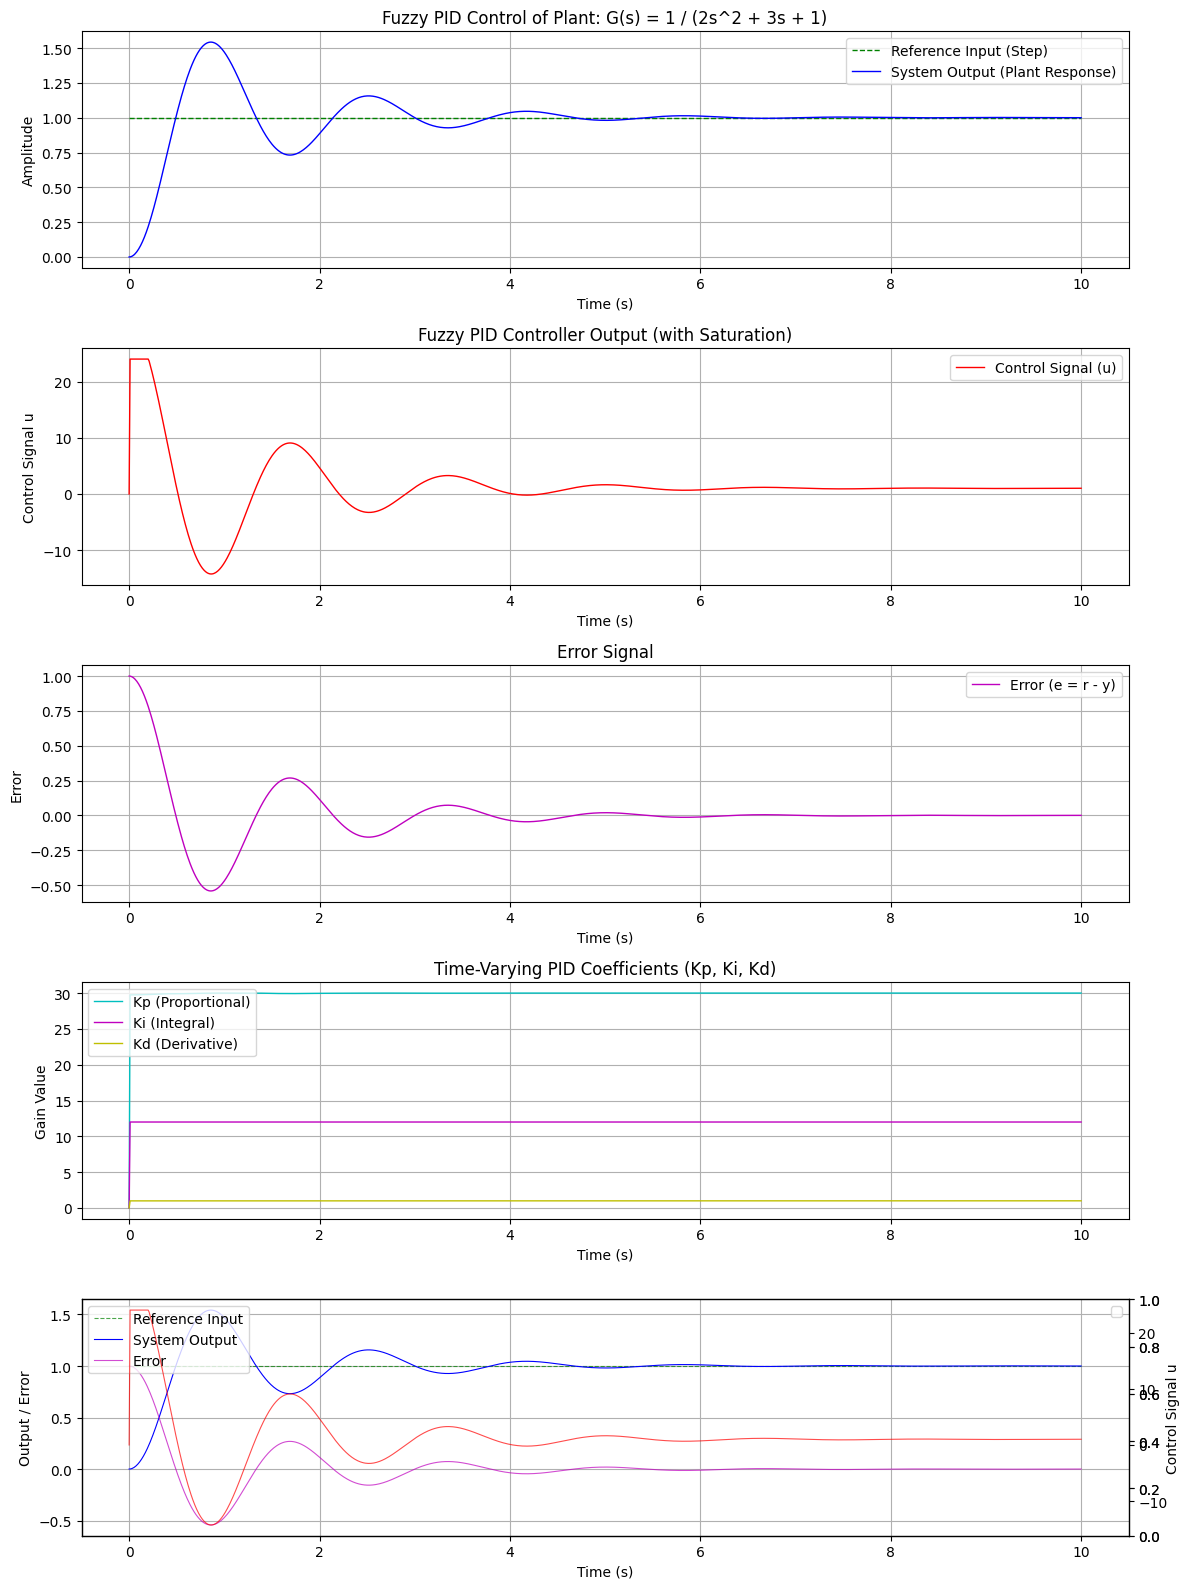


Final Output Value (at t=10.0s): 0.9999
Final Error Value (at t=10.0s): 0.0001
Final Control Signal Value (at t=10.0s): 1.0142
Final Kp Value (at t=10.0s): 30.0000
Final Ki Value (at t=10.0s): 12.0000
Final Kd Value (at t=10.0s): 1.0000
Steady-State Error (approx): 0.0001


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time

# --- Plant Definition ---
numerator = [1.0]
denominator = [2.0, 3.0, 1.0]
plant_tf = signal.TransferFunction(numerator, denominator)

# --- Discretization for Simulation ---
dt = 0.01  # Simulation time step (seconds)
# Discretize the plant using Zero-Order Hold (ZOH)
plant_discr = plant_tf.to_discrete(dt=dt, method='zoh')

# Extract discretized coefficients
# b0 z^0 + b1 z^-1 + b2 z^-2 + ... (numerator)
# ---------------------------
# 1 + a1 z^-1 + a2 z^-2 + ... (denominator starts from 1)
b_coeffs = plant_discr.num
a_coeffs = plant_discr.den # This starts with 1.0

print(f"Original Plant: num=[{numerator}], den=[{denominator}]")
print(f"Discretized Plant Numerator (b): {b_coeffs}")
print(f"Discretized Plant Denominator (a): {a_coeffs}")

# --- Fuzzy PID Controller Implementation ---

# Define Membership Functions for Error (E) and Change in Error (CE)
# Based on the C++ code's MF definitions
def E_NL(A):
    if A <= 0: return 1.0
    elif 0 < A <= 40: return (-A / 40.0 + 1.0)
    else: return 0.0

def E_NS(A):
    if 26 <= A <= 53: return (A - 26) / 27.0
    elif 53 < A <= 120: return (-A + 120) / 67.0
    else: return 0.0

def E_ZE(A):
    if 40 <= A <= 80: return A / 40.0 - 1.0
    elif 80 < A <= 120: return -A / 40.0 + 3.0
    else: return 0.0

def E_PS(A):
    if 40 <= A <= 106: return (A - 40) / 66.0
    elif 106 < A <= 133: return (-A + 133) / 27.0
    else: return 0.0

def E_PL(A):
    if A >= 160: return 1.0
    elif 120 <= A < 160: return A / 40.0 - 3.0
    else: return 0.0

def CE_NL(DA):
    if DA <= -1200: return 1.0
    elif -1200 < DA <= -900: return ((-DA) / 300.0 - 3.0)
    else: return 0.0

def CE_NS(DA):
    if -1080 < DA < -810: return (DA / 270.0 + 4.0)
    elif -810 <= DA < -300: return (-(DA + 300) / 510.0)
    else: return 0.0

def CE_ZE(DA):
    if -900 < DA < -600: return (DA / 300.0 + 3.0)
    elif -600 <= DA < -300: return ((-DA) / 300.0 - 1.0)
    else: return 0.0

def CE_PS(DA):
    if -900 < DA < -390: return (DA + 900) / 510.0
    elif -390 <= DA < -120: return (-(DA + 120) / 270.0)
    else: return 0.0

def CE_PL(DA):
    if DA >= 0: return 1.0
    elif -300 < DA < 0: return (DA / 300.0 + 1.0)
    else: return 0.0

# Define MF names for easier handling
E_MF_NAMES = ['NL', 'NS', 'ZE', 'PS', 'PL']
CE_MF_NAMES = ['NL', 'NS', 'ZE', 'PS', 'PL']

# Get MF functions
E_MF_FUNCS = [E_NL, E_NS, E_ZE, E_PS, E_PL]
CE_MF_FUNCS = [CE_NL, CE_NS, CE_ZE, CE_PS, CE_PL]

# --- Simulation Parameters ---
sim_time = 10.0  # Total simulation time (seconds)
num_steps = int(sim_time / dt) + 1

# Initialize arrays to store results
time_array = np.linspace(0, sim_time, num_steps)
reference_input = np.ones(num_steps) # Unit step input
system_output = np.zeros(num_steps)
control_signal = np.zeros(num_steps)
# Arrays to store time-varying PID coefficients
kp_values = np.zeros(num_steps)
ki_values = np.zeros(num_steps)
kd_values = np.zeros(num_steps)

# Controller state variables
error_prev = 0.0
integral_error = 0.0
# Initialize plant state variables (for difference equation)
# Need to pad initial values if the system order is less than expected (e.g., 2)
max_den_order = len(a_coeffs) - 1 # Order is length - 1 (excluding the leading 1)
max_num_order = len(b_coeffs) - 1
max_order_needed = max(max_den_order, max_num_order)

y_history = [0.0] * max_order_needed  # y(k-1), y(k-2), ...
u_history = [0.0] * max_num_order    # u(k-1), u(k-2), ... (numerator terms lag u by 1 or more)

print("Starting Simulation...")

# Simulation Loop
for i in range(1, num_steps): # Start from 1
    t = time_array[i]
    r = reference_input[i]

    # --- Plant Feedback ---
    # Current output y(k) is already calculated from the previous loop iteration
    y = system_output[i-1]

    # --- Fuzzy PID Controller Logic ---
    # Calculate error and change in error
    error = r - y
    error_change = (error - error_prev) / dt # Approximate derivative

    # Evaluate membership functions for current error and error_change
    e_mf_values = [mf(error) for mf in E_MF_FUNCS]
    ce_mf_values = [mf(error_change) for mf in CE_MF_FUNCS]

    # Apply rules and calculate crisp PID gains (Kp, Ki, Kd)
    sum_kp = 0.0
    sum_ki = 0.0
    sum_kd = 0.0
    num_fired_rules = 0

    for i_e, e_val in enumerate(e_mf_values):
        for i_ce, ce_val in enumerate(ce_mf_values):
            firing_strength = min(e_val, ce_val) # AND operation (Min)
            if firing_strength > 0: # Rule fires
                # --- Implement C++ Code's Gain Calculation Logic ---
                # Replicate the logic from the C++ code's if/else blocks based on i_e and i_ce.

                # Example for rule 0 (E=NL, CE=NL):
                if i_e == 0 and i_ce == 0: # E=NL, CE=NL
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2) # PVL
                    ki_val = 12 # PM
                    kd_val = (1 - dmin_val) / 3 # PVS
                elif i_e == 0 and i_ce == 1: # E=NL, CE=NS
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2) # PVL
                    ki_val = 12 # PM
                    kd_val = (5 - dmin_val) / 12 # PMS
                elif i_e == 0 and i_ce == 2: # E=NL, CE=ZE
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2) # PVL
                    ki_val = 12 # PM
                    kd_val = 0.5 # PM
                elif i_e == 0 and i_ce == 3: # E=NL, CE=PS
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2) # PVL
                    ki_val = 12 # PM
                    kd_val = (dmin_val + 9) / 12 # PL
                elif i_e == 0 and i_ce == 4: # E=NL, CE=PL
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2) # PVL
                    ki_val = 12 # PM
                    kd_val = (dmin_val + 2) / 3 # PVL
                elif i_e == 1 and i_ce == 0: # E=NS, CE=NL
                    dmin_val = firing_strength
                    kp_val = (5 * dmin_val + 35) / 2 # PML
                    ki_val = (10 - 2 * dmin_val) # PMS
                    kd_val = (5 - dmin_val) / 12 # PMS
                elif i_e == 1 and i_ce == 1: # E=NS, CE=NS
                    dmin_val = firing_strength
                    kp_val = (5 * dmin_val + 35) / 2 # PML
                    ki_val = (10 - 2 * dmin_val) # PMS
                    kd_val = (dmin_val + 7) / 12 # PML
                elif i_e == 1 and i_ce == 2: # E=NS, CE=ZE
                    dmin_val = firing_strength
                    kp_val = (5 * dmin_val + 35) / 2 # PML
                    ki_val = (10 - 2 * dmin_val) # PMS
                    kd_val = (dmin_val + 9) / 12 # PL
                elif i_e == 1 and i_ce == 3: # E=NS, CE=PS
                    dmin_val = firing_strength
                    kp_val = (5 * dmin_val + 45) / 2 # PL
                    ki_val = (10 - 2 * dmin_val) # PMS
                    kd_val = (dmin_val + 2) / 3 # PVL
                elif i_e == 1 and i_ce == 4: # E=NS, CE=PL
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2) # PVL
                    ki_val = (10 - 2 * dmin_val) # PMS
                    kd_val = (dmin_val + 2) / 3 # PVL
                elif i_e == 2 and i_ce == 0: # E=ZE, CE=NL
                    dmin_val = firing_strength
                    kp_val = (10 - 10 * dmin_val) # PVS
                    ki_val = (6 - 2 * dmin_val) # PS
                    kd_val = 0.5 # PM
                elif i_e == 2 and i_ce == 1: # E=ZE, CE=NS
                    dmin_val = firing_strength
                    kp_val = (10 - 10 * dmin_val) # PVS
                    ki_val = (6 - 2 * dmin_val) # PS
                    kd_val = (dmin_val + 9) / 12 # PL
                elif i_e == 2 and i_ce == 2: # E=ZE, CE=ZE
                    dmin_val = firing_strength
                    kp_val = (15 - 5 * dmin_val) / 2 # PS
                    ki_val = (8 - 8 * dmin_val) # PVS
                    kd_val = (dmin_val + 9) / 12 # PL
                elif i_e == 2 and i_ce == 3: # E=ZE, CE=PS
                    dmin_val = firing_strength
                    kp_val = (25 - 15 * dmin_val) / 2 # PMS
                    ki_val = (6 - 2 * dmin_val) # PS
                    kd_val = (dmin_val + 2) / 3 # PVL
                elif i_e == 2 and i_ce == 4: # E=ZE, CE=PL
                    dmin_val = firing_strength
                    kp_val = (25 - 15 * dmin_val) / 2 # PMS
                    ki_val = (6 - 2 * dmin_val) # PS
                    kd_val = (dmin_val + 2) / 3 # PVL
                elif i_e == 3 and i_ce == 0: # E=PS, CE=NL
                    dmin_val = firing_strength
                    kp_val = (10 - 10 * dmin_val) # PVS
                    ki_val = (dmin_val + 7) / 12 # PML
                    kd_val = (10 - 2 * dmin_val) # PMS
                elif i_e == 3 and i_ce == 1: # E=PS, CE=NS
                    dmin_val = firing_strength
                    kp_val = (10 - 10 * dmin_val) # PVS
                    ki_val = (10 - 2 * dmin_val) # PMS
                    kd_val = (dmin_val + 7) / 12 # PML
                elif i_e == 3 and i_ce == 2: # E=PS, CE=ZE
                    dmin_val = firing_strength
                    kp_val = (15 - 5 * dmin_val) / 2 # PS
                    ki_val = (10 - 2 * dmin_val) # PMS
                    kd_val = (dmin_val + 7) / 12 # PML
                elif i_e == 3 and i_ce == 3: # E=PS, CE=PS
                    dmin_val = firing_strength
                    kp_val = (25 - 15 * dmin_val) / 2 # PMS
                    ki_val = (10 - 2 * dmin_val) # PMS
                    kd_val = (dmin_val + 9) / 12 # PL
                elif i_e == 3 and i_ce == 4: # E=PS, CE=PL
                    dmin_val = firing_strength
                    kp_val = (25 - 15 * dmin_val) / 2 # PMS
                    ki_val = (10 - 2 * dmin_val) # PMS
                    kd_val = (dmin_val + 2) / 3 # PVL
                elif i_e == 4 and i_ce == 0: # E=PL, CE=NL
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2) # PVL
                    ki_val = 12 # PM
                    kd_val = (dmin_val + 2) / 3 # PVL
                elif i_e == 4 and i_ce == 1: # E=PL, CE=NS
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2) # PVL
                    ki_val = 12 # PM
                    kd_val = (dmin_val + 2) / 3 # PVL
                elif i_e == 4 and i_ce == 2: # E=PL, CE=ZE
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2) # PVL
                    ki_val = 12 # PM
                    kd_val = (dmin_val + 2) / 3 # PVL
                elif i_e == 4 and i_ce == 3: # E=PL, CE=PS
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2) # PVL
                    ki_val = 12 # PM
                    kd_val = (dmin_val + 2) / 3 # PVL
                elif i_e == 4 and i_ce == 4: # E=PL, CE=PL
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2) # PVL
                    ki_val = 12 # PM
                    kd_val = (dmin_val + 2) / 3 # PVL
                else:
                    # Should not happen if all 25 rules are covered
                    kp_val = 0.0
                    ki_val = 0.0
                    kd_val = 0.0

                sum_kp += kp_val
                sum_ki += ki_val
                sum_kd += kd_val
                num_fired_rules += 1

    # Calculate average gains (Mean of Maximums / Simplified Centroid)
    if num_fired_rules > 0:
        Kp = sum_kp / num_fired_rules
        Ki = sum_ki / num_fired_rules
        Kd = sum_kd / num_fired_rules
    else:
        # If no rules fire, gains are zero, controller output is zero
        Kp = 0.0
        Ki = 0.0
        Kd = 0.0

    # Store the calculated gains for plotting
    kp_values[i] = Kp
    ki_values[i] = Ki
    kd_values[i] = Kd

    # --- PID Calculation ---
    integral_error += error * dt
    # Derivative term is approximated by error_change calculated earlier
    derivative_error = error_change

    # Calculate control signal u(t)
    u = Kp * error + Ki * integral_error + Kd * derivative_error

    # Saturate control signal if needed (e.g., voltage limits)
    # The C++ code implies saturation (e.g., analogWrite range 0-255)
    # The paper mentions 24V limit. Let's apply a soft saturation here.
    # This is often needed for real actuators and can help simulation stability.
    saturation_limit = 24.0 # Volts, based on paper's mention of actuator rating
    u = np.clip(u, -saturation_limit, saturation_limit)

    control_signal[i] = u

    # --- Plant Update (Difference Equation) ---
    # y(k) = b0*u(k) + b1*u(k-1) + b2*u(k-2) + ... - a1*y(k-1) - a2*y(k-2) - ...
    # Note: a_coeffs[0] is always 1. We use a1 = a_coeffs[1], a2 = a_coeffs[2], etc.
    # Ensure we have enough history values, padded with zeros initially if needed.

    output_sum = 0.0
    # Add terms from the input (u)
    for j in range(len(b_coeffs)):
        if j == 0:
            output_sum += b_coeffs[j] * u # Current input u(k)
        else:
            # Use u_history[j-1] which corresponds to u(k-j)
            # u_history[0] is u(k-1), u_history[1] is u(k-2), etc.
            if j-1 < len(u_history):
                 output_sum += b_coeffs[j] * u_history[j-1]
            else:
                 # If history is not long enough (shouldn't happen with correct padding)
                 output_sum += 0.0

    # Subtract terms from the output (y)
    for j in range(1, len(a_coeffs)): # Start from 1 to skip the leading 1.0
        # Use y_history[j-1] which corresponds to y(k-j)
        # y_history[0] is y(k-1), y_history[1] is y(k-2), etc.
        if j-1 < len(y_history):
             output_sum -= a_coeffs[j] * y_history[j-1]
        else:
             # If history is not long enough (shouldn't happen with correct padding)
             output_sum -= 0.0

    y_new = output_sum
    system_output[i] = y_new

    # Update history for next iteration
    # Shift history arrays and add new values
    # Y history
    if len(y_history) > 0:
        y_history = [y_new] + y_history[:-1] # Add new y to front, remove last
    # U history (numerator order might be different)
    if len(u_history) > 0:
        u_history = [u] + u_history[:-1] # Add new u to front, remove last

    # Update controller state for next iteration
    error_prev = error

print("Simulation Complete.")

# --- Plotting ---
fig, axs = plt.subplots(5, 1, figsize=(12, 16))

# Plot 1: System Output
axs[0].plot(time_array, reference_input, 'g--', label='Reference Input (Step)', linewidth=1)
axs[0].plot(time_array, system_output, 'b-', label='System Output (Plant Response)', linewidth=1)
axs[0].set_title('Fuzzy PID Control of Plant: G(s) = 1 / (2s^2 + 3s + 1)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Control Signal
axs[1].plot(time_array, control_signal, 'r-', label='Control Signal (u)', linewidth=1)
axs[1].set_title('Fuzzy PID Controller Output (with Saturation)')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Control Signal u')
axs[1].legend()
axs[1].grid(True)

# Plot 3: Error
error_signal = reference_input - system_output
axs[2].plot(time_array, error_signal, 'm-', label='Error (e = r - y)', linewidth=1)
axs[2].set_title('Error Signal')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Error')
axs[2].legend()
axs[2].grid(True)

# Plot 4: PID Coefficients
axs[3].plot(time_array, kp_values, 'c-', label='Kp (Proportional)', linewidth=1)
axs[3].plot(time_array, ki_values, 'm-', label='Ki (Integral)', linewidth=1)
axs[3].plot(time_array, kd_values, 'y-', label='Kd (Derivative)', linewidth=1)
axs[3].set_title('Time-Varying PID Coefficients (Kp, Ki, Kd)')
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Gain Value')
axs[3].legend()
axs[3].grid(True)

# Plot 5: Combined System Response, Error, and Control Signal for overview
axs[4].plot(time_array, reference_input, 'g--', label='Reference Input', linewidth=0.8, alpha=0.7)
axs[4].plot(time_array, system_output, 'b-', label='System Output', linewidth=0.8)
axs[4].plot(time_array, error_signal, 'm-', label='Error', linewidth=0.8, alpha=0.7)
axs[4].twinx().plot(time_array, control_signal, 'r-', label='Control Signal', linewidth=0.8, alpha=0.7)
axs[4].set_xlabel('Time (s)')
axs[4].set_ylabel('Output / Error')
axs[4].twinx().set_ylabel('Control Signal u')
axs[4].legend(loc='upper left')
axs[4].twinx().legend(loc='upper right')
axs[4].grid(True)

plt.tight_layout()
plt.show()

# --- Print Final Values ---
print(f"\nFinal Output Value (at t={sim_time}s): {system_output[-1]:.4f}")
print(f"Final Error Value (at t={sim_time}s): {error_signal[-1]:.4f}")
print(f"Final Control Signal Value (at t={sim_time}s): {control_signal[-1]:.4f}")
print(f"Final Kp Value (at t={sim_time}s): {kp_values[-1]:.4f}")
print(f"Final Ki Value (at t={sim_time}s): {ki_values[-1]:.4f}")
print(f"Final Kd Value (at t={sim_time}s): {kd_values[-1]:.4f}")

# Print steady-state error (error at the end)
ss_error = abs(error_signal[-1])
print(f"Steady-State Error (approx): {ss_error:.4f}")


# Compare outputs Fuzzy and Plant

The closed-loop plant update follows the difference equation:

`y(k) = b0*u(k) + b1*u(k-1) + b2*u(k-2) + ... - a1*y(k-1) - a2*y(k-2) - ...`

This specific form arises from the mathematical process of converting a continuous-time transfer function `G(s) = Y(s)/U(s)` into a discrete-time transfer function `G(z) = Y(z)/U(z)`, and then converting that discrete transfer function into a difference equation that relates the current output `y(k)` to past outputs `y(k-1), y(k-2), ...` and current/past inputs `u(k), u(k-1), u(k-2), ...`.

1.  **Continuous to Discrete Transfer Function:** The simulation starts with a continuous-time plant model (like the one derived in the paper, e.g., Eq. 9 or 17). This is represented by a transfer function `G(s) = Num(s)/Den(s)`, where `Num(s)` and `Den(s)` are polynomials in `s`. The `scipy.signal.TransferFunction.to_discrete` method (using methods like 'zoh' - Zero Order Hold) converts this `G(s)` into an equivalent discrete-time transfer function `G(z) = Num(z)/Den(z)`. This `G(z)` has the form:
    `G(z) = (b0 + b1*z^-1 + b2*z^-2 + ...) / (1 + a1*z^-1 + a2*z^-2 + ...)`
    Here, `z^-1` is the unit delay operator (meaning `z^-1 * X(z)` corresponds to `x(k-1)` in the time domain).

2.  **Transfer Function Relationship:** By definition, `Y(z) = G(z) * U(z)`. Substituting the form of `G(z)`:
    `Y(z) = [(b0 + b1*z^-1 + b2*z^-2 + ...) / (1 + a1*z^-1 + a2*z^-2 + ...)] * U(z)`

3.  **Rearranging:** Multiply both sides by the denominator of `G(z)`:
    `(1 + a1*z^-1 + a2*z^-2 + ...) * Y(z) = (b0 + b1*z^-1 + b2*z^-2 + ...) * U(z)`

4.  **Expanding Both Sides:**
    `Y(z) + a1*z^-1*Y(z) + a2*z^-2*Y(z) + ... = b0*U(z) + b1*z^-1*U(z) + b2*z^-2*U(z) + ...`

5.  **Applying Inverse Z-Transform:** The inverse Z-transform converts this equation from the `z` domain back to the time domain `k`. Remember that `z^-n * X(z)` transforms to `x(k-n)`:
    `y(k) + a1*y(k-1) + a2*y(k-2) + ... = b0*u(k) + b1*u(k-1) + b2*u(k-2) + ...`

6.  **Solving for the Current Output `y(k)`:** To find the output at the current time step `k`, we rearrange the equation to isolate `y(k)`:
    `y(k) = b0*u(k) + b1*u(k-1) + b2*u(k-2) + ... - a1*y(k-1) - a2*y(k-2) - ...`

This final equation is the difference equation. It explicitly calculates the current output `y(k)` based on the current input `u(k)`, the past inputs `u(k-1), u(k-2), ...`, and the past outputs `y(k-1), y(k-2), ...`.

Nominal Plant (Continuous): num=[[1.0]], den=[[2.0, 3.0, 1.0]]
Nominal Plant (Discrete): num=[[2.48753638e-05 2.47512974e-05]], den=[[ 1.         -1.98506231  0.98511194]]
Starting Closed-Loop Simulation with Plant Parameter Variation...
Closed-Loop Simulation Complete.
Starting Open-Loop Simulation with Plant Parameter Variation...
Open-Loop Simulation with Varying Parameters Complete.
Starting Open-Loop Simulation with Nominal Plant (No Disturbance)...
Open-Loop Simulation with Nominal Plant Complete.


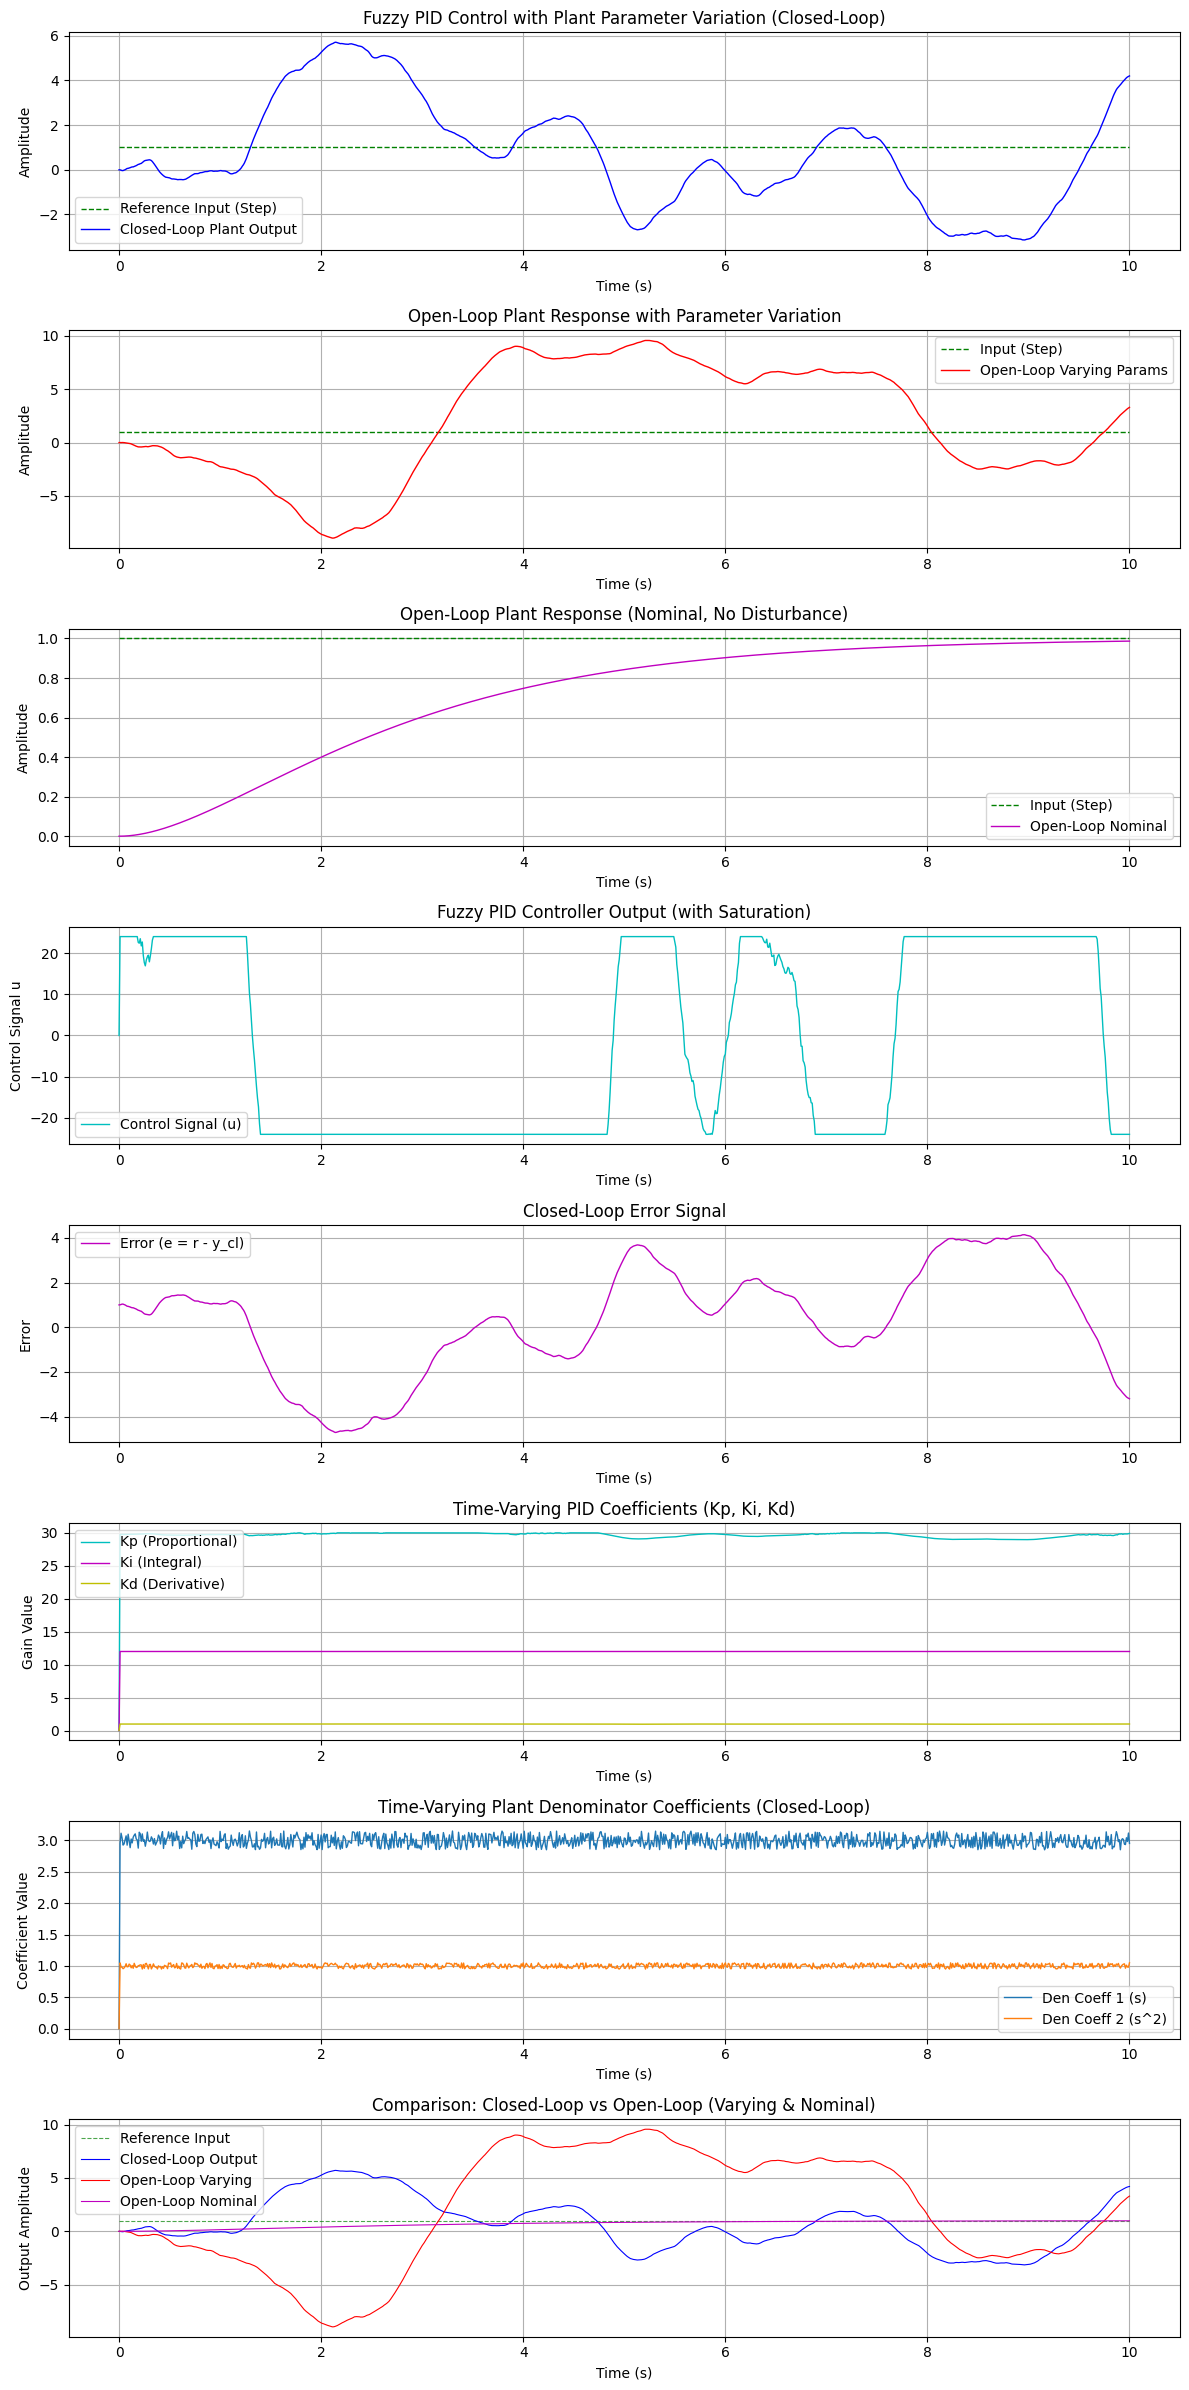


--- Closed-Loop Final Values ---
Final Plant Output Value (at t=10.0s): 4.2047
Final Error Value (at t=10.0s): -3.2047
Final Control Signal Value (at t=10.0s): -24.0000
Final Kp Value (at t=10.0s): 29.9105
Final Ki Value (at t=10.0s): 12.0000
Final Kd Value (at t=10.0s): 0.9970
Final Plant Denominator Coefficients (at t=10.0s): [2.95159935 1.04981299]

--- Open-Loop (Varying) Final Values ---
Final Open-Loop Output Value (Varying Params, at t=10.0s): 3.3028

--- Open-Loop (Nominal) Final Values ---
Final Open-Loop Output Value (Nominal, at t=10.0s): 0.9866

Steady-State Error (Closed-Loop, approx): 3.2047
Final Input-Output Difference (Open-Loop Varying, approx): 2.3028
Final Input-Output Difference (Open-Loop Nominal, approx): 0.0134


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time

# --- Nominal Plant Definition ---
nominal_numerator = [1.0]
nominal_denominator = [2.0, 3.0, 1.0]
nominal_plant_tf = signal.TransferFunction(nominal_numerator, nominal_denominator)

# --- Discretization Parameters ---
dt = 0.01  # Simulation time step (seconds)
# Discretize the *nominal* plant once for the nominal open-loop simulation
nominal_plant_discr = nominal_plant_tf.to_discrete(dt=dt, method='zoh')
nominal_b_coeffs = nominal_plant_discr.num
nominal_a_coeffs = nominal_plant_discr.den # This starts with 1.0

print(f"Nominal Plant (Continuous): num=[{nominal_numerator}], den=[{nominal_denominator}]")
print(f"Nominal Plant (Discrete): num=[{nominal_b_coeffs}], den=[{nominal_a_coeffs}]")

# --- Fuzzy PID Controller Implementation ---

# Define Membership Functions for Error (E) and Change in Error (CE)
# Based on the C++ code's MF definitions
def E_NL(A):
    if A <= 0: return 1.0
    elif 0 < A <= 40: return (-A / 40.0 + 1.0)
    else: return 0.0

def E_NS(A):
    if 26 <= A <= 53: return (A - 26) / 27.0
    elif 53 < A <= 120: return (-A + 120) / 67.0
    else: return 0.0

def E_ZE(A):
    if 40 <= A <= 80: return A / 40.0 - 1.0
    elif 80 < A <= 120: return -A / 40.0 + 3.0
    else: return 0.0

def E_PS(A):
    if 40 <= A <= 106: return (A - 40) / 66.0
    elif 106 < A <= 133: return (-A + 133) / 27.0
    else: return 0.0

def E_PL(A):
    if A >= 160: return 1.0
    elif 120 <= A < 160: return A / 40.0 - 3.0
    else: return 0.0

def CE_NL(DA):
    if DA <= -1200: return 1.0
    elif -1200 < DA <= -900: return ((-DA) / 300.0 - 3.0)
    else: return 0.0

def CE_NS(DA):
    if -1080 < DA < -810: return (DA / 270.0 + 4.0)
    elif -810 <= DA < -300: return (-(DA + 300) / 510.0)
    else: return 0.0

def CE_ZE(DA):
    if -900 < DA < -600: return (DA / 300.0 + 3.0)
    elif -600 <= DA < -300: return ((-DA) / 300.0 - 1.0)
    else: return 0.0

def CE_PS(DA):
    if -900 < DA < -390: return (DA + 900) / 510.0
    elif -390 <= DA < -120: return (-(DA + 120) / 270.0)
    else: return 0.0

def CE_PL(DA):
    if DA >= 0: return 1.0
    elif -300 < DA < 0: return (DA / 300.0 + 1.0)
    else: return 0.0

# Define MF names for easier handling
E_MF_NAMES = ['NL', 'NS', 'ZE', 'PS', 'PL']
CE_MF_NAMES = ['NL', 'NS', 'ZE', 'PS', 'PL']

# Get MF functions
E_MF_FUNCS = [E_NL, E_NS, E_ZE, E_PS, E_PL]
CE_MF_FUNCS = [CE_NL, CE_NS, CE_ZE, CE_PS, CE_PL]

# --- Plant Parameter Variation ---
# Define the percentage range for random variation (e.g., +/- 5%)
param_variation_pct = 0.05 # 5% variation

def get_random_plant_params(nominal_num, nominal_den, variation_pct):
    """Generates random numerator and denominator coefficients."""
    random_num = [np.random.uniform(n * (1 - variation_pct), n * (1 + variation_pct)) for n in nominal_num]
    # Ensure the leading coefficient of the denominator remains positive and significant
    random_den = [nominal_den[0]] + [np.random.uniform(n * (1 - variation_pct), n * (1 + variation_pct)) for n in nominal_den[1:]]
    # Ensure the leading coefficient is not zero or negative (for stability reasons)
    if random_den[0] <= 0:
        random_den[0] = 1.0 # Or handle differently if needed
    return random_num, random_den

# --- Simulation Parameters ---
sim_time = 10.0  # Total simulation time (seconds)
num_steps = int(sim_time / dt) + 1

# Initialize arrays to store results
time_array = np.linspace(0, sim_time, num_steps)
reference_input = np.ones(num_steps) # Unit step input

# Closed-Loop Simulation Variables
plant_output = np.zeros(num_steps) # Closed-loop plant output (with controller)
control_signal = np.zeros(num_steps)
# Arrays to store time-varying PID coefficients
kp_values = np.zeros(num_steps)
ki_values = np.zeros(num_steps)
kd_values = np.zeros(num_steps)
# Arrays to store varying plant coefficients (for monitoring)
plant_num_values = np.zeros((num_steps, len(nominal_numerator)))
plant_den_values = np.zeros((num_steps, len(nominal_denominator)))
# Controller state variables
error_prev = 0.0
integral_error = 0.0
# Initialize plant state variables (for difference equation)
max_nominal_order = max(len(nominal_denominator), len(nominal_numerator)) - 1
cl_y_history = [0.0] * max_nominal_order # History of plant outputs y(k-1), y(k-2), ...
cl_u_history = [0.0] * (max_nominal_order) # History of control inputs u(k-1), u(k-2), ...

# Open-Loop Simulation Variables (with random parameters)
open_loop_varying_output = np.zeros(num_steps) # Open-loop plant output (with varying params)
# State variables for open-loop simulation
ol_var_y_history = [0.0] * max_nominal_order
ol_var_u_history = [0.0] * (max_nominal_order)

# Open-Loop Simulation Variables (nominal plant, no disturbance)
open_loop_nominal_output = np.zeros(num_steps) # Open-loop plant output (nominal, no disturbance)
# State variables for open-loop simulation
ol_nom_y_history = [0.0] * max_nominal_order
ol_nom_u_history = [0.0] * (max_nominal_order)

print("Starting Closed-Loop Simulation with Plant Parameter Variation...")

# Simulation Loop - Closed Loop
for i in range(1, num_steps): # Start from 1
    t = time_array[i]
    r = reference_input[i]

    # --- Plant Parameter Variation and Discretization (Closed Loop) ---
    current_num, current_den = get_random_plant_params(nominal_numerator, nominal_denominator, param_variation_pct)
    current_plant_tf = signal.TransferFunction(current_num, current_den)
    current_plant_discr = current_plant_tf.to_discrete(dt=dt, method='zoh')
    current_b_coeffs = current_plant_discr.num
    current_a_coeffs = current_plant_discr.den # This starts with 1.0

    # Store the current coefficients for plotting
    plant_num_values[i, :len(current_num)] = current_num
    plant_den_values[i, 0] = current_den[0]
    plant_den_values[i, 1:len(current_den)] = current_den[1:]

    # --- Plant Feedback (Closed Loop) ---
    y = cl_y_history[0] # y(k-1) is the first element in the history list

    # --- Fuzzy PID Controller Logic (Closed Loop) ---
    error = r - y
    error_change = (error - error_prev) / dt # Approximate derivative

    # Evaluate membership functions for current error and error_change
    e_mf_values = [mf(error) for mf in E_MF_FUNCS]
    ce_mf_values = [mf(error_change) for mf in CE_MF_FUNCS]

    # Apply rules and calculate crisp PID gains (Kp, Ki, Kd)
    sum_kp = 0.0
    sum_ki = 0.0
    sum_kd = 0.0
    num_fired_rules = 0

    for i_e, e_val in enumerate(e_mf_values):
        for i_ce, ce_val in enumerate(ce_mf_values):
            firing_strength = min(e_val, ce_val) # AND operation (Min)
            if firing_strength > 0: # Rule fires
                # --- Implement C++ Code's Gain Calculation Logic ---
                # Example for rule 0 (E=NL, CE=NL):
                if i_e == 0 and i_ce == 0: # E=NL, CE=NL
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2)
                    ki_val = 12
                    kd_val = (1 - dmin_val) / 3
                elif i_e == 0 and i_ce == 1: # E=NL, CE=NS
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2)
                    ki_val = 12
                    kd_val = (5 - dmin_val) / 12
                elif i_e == 0 and i_ce == 2: # E=NL, CE=ZE
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2)
                    ki_val = 12
                    kd_val = 0.5
                elif i_e == 0 and i_ce == 3: # E=NL, CE=PS
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2)
                    ki_val = 12
                    kd_val = (dmin_val + 9) / 12
                elif i_e == 0 and i_ce == 4: # E=NL, CE=PL
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2)
                    ki_val = 12
                    kd_val = (dmin_val + 2) / 3
                elif i_e == 1 and i_ce == 0: # E=NS, CE=NL
                    dmin_val = firing_strength
                    kp_val = (5 * dmin_val + 35) / 2
                    ki_val = (10 - 2 * dmin_val)
                    kd_val = (5 - dmin_val) / 12
                elif i_e == 1 and i_ce == 1: # E=NS, CE=NS
                    dmin_val = firing_strength
                    kp_val = (5 * dmin_val + 35) / 2
                    ki_val = (10 - 2 * dmin_val)
                    kd_val = (dmin_val + 7) / 12
                elif i_e == 1 and i_ce == 2: # E=NS, CE=ZE
                    dmin_val = firing_strength
                    kp_val = (5 * dmin_val + 35) / 2
                    ki_val = (10 - 2 * dmin_val)
                    kd_val = (dmin_val + 9) / 12
                elif i_e == 1 and i_ce == 3: # E=NS, CE=PS
                    dmin_val = firing_strength
                    kp_val = (5 * dmin_val + 45) / 2
                    ki_val = (10 - 2 * dmin_val)
                    kd_val = (dmin_val + 2) / 3
                elif i_e == 1 and i_ce == 4: # E=NS, CE=PL
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2)
                    ki_val = (10 - 2 * dmin_val)
                    kd_val = (dmin_val + 2) / 3
                elif i_e == 2 and i_ce == 0: # E=ZE, CE=NL
                    dmin_val = firing_strength
                    kp_val = (10 - 10 * dmin_val)
                    ki_val = (6 - 2 * dmin_val)
                    kd_val = 0.5
                elif i_e == 2 and i_ce == 1: # E=ZE, CE=NS
                    dmin_val = firing_strength
                    kp_val = (10 - 10 * dmin_val)
                    ki_val = (6 - 2 * dmin_val)
                    kd_val = (dmin_val + 9) / 12
                elif i_e == 2 and i_ce == 2: # E=ZE, CE=ZE
                    dmin_val = firing_strength
                    kp_val = (15 - 5 * dmin_val) / 2
                    ki_val = (8 - 8 * dmin_val)
                    kd_val = (dmin_val + 9) / 12
                elif i_e == 2 and i_ce == 3: # E=ZE, CE=PS
                    dmin_val = firing_strength
                    kp_val = (25 - 15 * dmin_val) / 2
                    ki_val = (6 - 2 * dmin_val)
                    kd_val = (dmin_val + 2) / 3
                elif i_e == 2 and i_ce == 4: # E=ZE, CE=PL
                    dmin_val = firing_strength
                    kp_val = (25 - 15 * dmin_val) / 2
                    ki_val = (6 - 2 * dmin_val)
                    kd_val = (dmin_val + 2) / 3
                elif i_e == 3 and i_ce == 0: # E=PS, CE=NL
                    dmin_val = firing_strength
                    kp_val = (10 - 10 * dmin_val)
                    ki_val = (dmin_val + 7) / 12
                    kd_val = (10 - 2 * dmin_val)
                elif i_e == 3 and i_ce == 1: # E=PS, CE=NS
                    dmin_val = firing_strength
                    kp_val = (10 - 10 * dmin_val)
                    ki_val = (10 - 2 * dmin_val)
                    kd_val = (dmin_val + 7) / 12
                elif i_e == 3 and i_ce == 2: # E=PS, CE=ZE
                    dmin_val = firing_strength
                    kp_val = (15 - 5 * dmin_val) / 2
                    ki_val = (10 - 2 * dmin_val)
                    kd_val = (dmin_val + 7) / 12
                elif i_e == 3 and i_ce == 3: # E=PS, CE=PS
                    dmin_val = firing_strength
                    kp_val = (25 - 15 * dmin_val) / 2
                    ki_val = (10 - 2 * dmin_val)
                    kd_val = (dmin_val + 9) / 12
                elif i_e == 3 and i_ce == 4: # E=PS, CE=PL
                    dmin_val = firing_strength
                    kp_val = (25 - 15 * dmin_val) / 2
                    ki_val = (10 - 2 * dmin_val)
                    kd_val = (dmin_val + 2) / 3
                elif i_e == 4 and i_ce == 0: # E=PL, CE=NL
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2)
                    ki_val = 12
                    kd_val = (dmin_val + 2) / 3
                elif i_e == 4 and i_ce == 1: # E=PL, CE=NS
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2)
                    ki_val = 12
                    kd_val = (dmin_val + 2) / 3
                elif i_e == 4 and i_ce == 2: # E=PL, CE=ZE
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2)
                    ki_val = 12
                    kd_val = (dmin_val + 2) / 3
                elif i_e == 4 and i_ce == 3: # E=PL, CE=PS
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2)
                    ki_val = 12
                    kd_val = (dmin_val + 2) / 3
                elif i_e == 4 and i_ce == 4: # E=PL, CE=PL
                    dmin_val = firing_strength
                    kp_val = 10 * (dmin_val + 2)
                    ki_val = 12
                    kd_val = (dmin_val + 2) / 3
                else:
                    kp_val = 0.0
                    ki_val = 0.0
                    kd_val = 0.0

                sum_kp += kp_val
                sum_ki += ki_val
                sum_kd += kd_val
                num_fired_rules += 1

    # Calculate average gains (Mean of Maximums / Simplified Centroid)
    if num_fired_rules > 0:
        Kp = sum_kp / num_fired_rules
        Ki = sum_ki / num_fired_rules
        Kd = sum_kd / num_fired_rules
    else:
        Kp = 0.0
        Ki = 0.0
        Kd = 0.0

    # Store the calculated gains for plotting
    kp_values[i] = Kp
    ki_values[i] = Ki
    kd_values[i] = Kd

    # --- PID Calculation (Closed Loop) ---
    integral_error += error * dt
    derivative_error = error_change
    u_controlled = Kp * error + Ki * integral_error + Kd * derivative_error

    # Saturate control signal if needed (e.g., voltage limits)
    saturation_limit = 24.0
    u_controlled = np.clip(u_controlled, -saturation_limit, saturation_limit)
    control_signal[i] = u_controlled

    # --- Plant Update (Difference Equation) - Closed Loop (using control signal) ---
    # Use the *current* plant coefficients calculated above
    output_sum = 0.0
    # Add terms from the input (u_controlled)
    for j in range(len(current_b_coeffs)):
        if j == 0:
            output_sum += current_b_coeffs[j] * u_controlled # Current input u(k)
        else:
            # Use cl_u_history[j-1] which corresponds to u(k-j)
            if j-1 < len(cl_u_history):
                 output_sum += current_b_coeffs[j] * cl_u_history[j-1]
            else:
                 output_sum += 0.0

    # Subtract terms from the output (y)
    for j in range(1, len(current_a_coeffs)): # Start from 1 to skip the leading 1.0
        # Use cl_y_history[j-1] which corresponds to y(k-j)
        if j-1 < len(cl_y_history):
             output_sum -= current_a_coeffs[j] * cl_y_history[j-1]
        else:
             output_sum -= 0.0

    # Add Disturbance
    disturbance_magnitude = 0.01
    current_disturbance = np.random.normal(loc=0.0, scale=disturbance_magnitude)
    y_new_closed_loop = output_sum + current_disturbance
    plant_output[i] = y_new_closed_loop

    # Update history for next iteration (Closed Loop)
    cl_y_history = [y_new_closed_loop] + cl_y_history[:max_nominal_order-1]
    cl_u_history = [u_controlled] + cl_u_history[:max_nominal_order-1]

    # Update controller state for next iteration
    error_prev = error

print("Closed-Loop Simulation Complete.")

# --- Open-Loop Simulation with Random Plant Parameters ---
print("Starting Open-Loop Simulation with Plant Parameter Variation...")

for i in range(1, num_steps): # Start from 1
    t = time_array[i]
    r = reference_input[i] # Step input is the plant input for open-loop

    # --- Plant Parameter Variation and Discretization (Open Loop) ---
    # Generate *new* random parameters for this time step in open-loop
    ol_current_num, ol_current_den = get_random_plant_params(nominal_numerator, nominal_denominator, param_variation_pct)
    ol_current_plant_tf = signal.TransferFunction(ol_current_num, ol_current_den)
    ol_current_plant_discr = ol_current_plant_tf.to_discrete(dt=dt, method='zoh')
    ol_current_b_coeffs = ol_current_plant_discr.num
    ol_current_a_coeffs = ol_current_plant_discr.den # This starts with 1.0

    # --- Plant Update (Difference Equation) - Open Loop (using step input r) ---
    # Use the *current* open-loop plant coefficients calculated above
    ol_output_sum = 0.0
    # Add terms from the input (r, the step input)
    for j in range(len(ol_current_b_coeffs)):
        if j == 0:
            ol_output_sum += ol_current_b_coeffs[j] * r # Current input r(k)
        else:
            # Use ol_var_u_history[j-1] which corresponds to r(k-j) (step input history)
            if j-1 < len(ol_var_u_history):
                 ol_output_sum += ol_current_b_coeffs[j] * ol_var_u_history[j-1]
            else:
                 ol_output_sum += 0.0

    # Subtract terms from the output (y)
    for j in range(1, len(ol_current_a_coeffs)): # Start from 1 to skip the leading 1.0
        # Use ol_var_y_history[j-1] which corresponds to y(k-j)
        if j-1 < len(ol_var_y_history):
             ol_output_sum -= ol_current_a_coeffs[j] * ol_var_y_history[j-1]
        else:
             ol_output_sum -= 0.0

    # Add Disturbance (for open-loop as well, if desired)
    # Using the same magnitude for comparison, though it might differ in reality
    ol_current_disturbance = np.random.normal(loc=0.0, scale=disturbance_magnitude)
    y_new_open_loop_varying = ol_output_sum + ol_current_disturbance
    open_loop_varying_output[i] = y_new_open_loop_varying

    # Update history for next iteration (Open Loop - Varying)
    ol_var_y_history = [y_new_open_loop_varying] + ol_var_y_history[:max_nominal_order-1]
    ol_var_u_history = [r] + ol_var_u_history[:max_nominal_order-1] # Update input history with step input r

print("Open-Loop Simulation with Varying Parameters Complete.")

# --- Open-Loop Simulation with Nominal Plant (No Disturbance) ---
print("Starting Open-Loop Simulation with Nominal Plant (No Disturbance)...")

for i in range(1, num_steps): # Start from 1
    t = time_array[i]
    r = reference_input[i] # Step input is the plant input for open-loop

    # --- Plant Update (Difference Equation) - Open Loop (using nominal plant, no disturbance) ---
    # Use the *nominal* plant coefficients calculated once at the beginning
    ol_nom_output_sum = 0.0
    # Add terms from the input (r, the step input)
    for j in range(len(nominal_b_coeffs)):
        if j == 0:
            ol_nom_output_sum += nominal_b_coeffs[j] * r # Current input r(k)
        else:
            # Use ol_nom_u_history[j-1] which corresponds to r(k-j) (step input history)
            if j-1 < len(ol_nom_u_history):
                 ol_nom_output_sum += nominal_b_coeffs[j] * ol_nom_u_history[j-1]
            else:
                 ol_nom_output_sum += 0.0

    # Subtract terms from the output (y)
    for j in range(1, len(nominal_a_coeffs)): # Start from 1 to skip the leading 1.0
        # Use ol_nom_y_history[j-1] which corresponds to y(k-j)
        if j-1 < len(ol_nom_y_history):
             ol_nom_output_sum -= nominal_a_coeffs[j] * ol_nom_y_history[j-1]
        else:
             ol_nom_output_sum -= 0.0

    # No Disturbance added for nominal case
    y_new_open_loop_nominal = ol_nom_output_sum # + 0.0
    open_loop_nominal_output[i] = y_new_open_loop_nominal

    # Update history for next iteration (Open Loop - Nominal)
    ol_nom_y_history = [y_new_open_loop_nominal] + ol_nom_y_history[:max_nominal_order-1]
    ol_nom_u_history = [r] + ol_nom_u_history[:max_nominal_order-1] # Update input history with step input r

print("Open-Loop Simulation with Nominal Plant Complete.")

# --- Plotting ---
fig, axs = plt.subplots(8, 1, figsize=(12, 24))

# Plot 1: Closed-Loop Plant Output
axs[0].plot(time_array, reference_input, 'g--', label='Reference Input (Step)', linewidth=1)
axs[0].plot(time_array, plant_output, 'b-', label='Closed-Loop Plant Output', linewidth=1)
axs[0].set_title('Fuzzy PID Control with Plant Parameter Variation (Closed-Loop)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Open-Loop Plant Output (Varying Parameters)
axs[1].plot(time_array, reference_input, 'g--', label='Input (Step)', linewidth=1)
axs[1].plot(time_array, open_loop_varying_output, 'r-', label='Open-Loop Varying Params', linewidth=1)
axs[1].set_title('Open-Loop Plant Response with Parameter Variation')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].legend()
axs[1].grid(True)

# Plot 3: Open-Loop Plant Output (Nominal)
axs[2].plot(time_array, reference_input, 'g--', label='Input (Step)', linewidth=1)
axs[2].plot(time_array, open_loop_nominal_output, 'm-', label='Open-Loop Nominal', linewidth=1)
axs[2].set_title('Open-Loop Plant Response (Nominal, No Disturbance)')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Amplitude')
axs[2].legend()
axs[2].grid(True)

# Plot 4: Control Signal
axs[3].plot(time_array, control_signal, 'c-', label='Control Signal (u)', linewidth=1)
axs[3].set_title('Fuzzy PID Controller Output (with Saturation)')
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Control Signal u')
axs[3].legend()
axs[3].grid(True)

# Plot 5: Error (Closed-Loop)
error_signal = reference_input - plant_output
axs[4].plot(time_array, error_signal, 'm-', label='Error (e = r - y_cl)', linewidth=1)
axs[4].set_title('Closed-Loop Error Signal')
axs[4].set_xlabel('Time (s)')
axs[4].set_ylabel('Error')
axs[4].legend()
axs[4].grid(True)

# Plot 6: PID Coefficients
axs[5].plot(time_array, kp_values, 'c-', label='Kp (Proportional)', linewidth=1)
axs[5].plot(time_array, ki_values, 'm-', label='Ki (Integral)', linewidth=1)
axs[5].plot(time_array, kd_values, 'y-', label='Kd (Derivative)', linewidth=1)
axs[5].set_title('Time-Varying PID Coefficients (Kp, Ki, Kd)')
axs[5].set_xlabel('Time (s)')
axs[5].set_ylabel('Gain Value')
axs[5].legend()
axs[5].grid(True)

# Plot 7: Varying Plant Parameters (Denominator coefficients for example)
axs[6].plot(time_array, plant_den_values[:, 1], label='Den Coeff 1 (s)', linewidth=1) # a1
axs[6].plot(time_array, plant_den_values[:, 2], label='Den Coeff 2 (s^2)', linewidth=1) # a2
axs[6].set_title('Time-Varying Plant Denominator Coefficients (Closed-Loop)')
axs[6].set_xlabel('Time (s)')
axs[6].set_ylabel('Coefficient Value')
axs[6].legend()
axs[6].grid(True)

# Plot 8: Combined Comparison: Closed-Loop, Open-Loop Varying, Open-Loop Nominal
axs[7].plot(time_array, reference_input, 'g--', label='Reference Input', linewidth=0.8, alpha=0.7)
axs[7].plot(time_array, plant_output, 'b-', label='Closed-Loop Output', linewidth=0.8)
axs[7].plot(time_array, open_loop_varying_output, 'r-', label='Open-Loop Varying', linewidth=0.8)
axs[7].plot(time_array, open_loop_nominal_output, 'm-', label='Open-Loop Nominal', linewidth=0.8)
axs[7].set_title('Comparison: Closed-Loop vs Open-Loop (Varying & Nominal)')
axs[7].set_xlabel('Time (s)')
axs[7].set_ylabel('Output Amplitude')
axs[7].legend()
axs[7].grid(True)

plt.tight_layout()
plt.show()

# --- Print Final Values ---
print(f"\n--- Closed-Loop Final Values ---")
print(f"Final Plant Output Value (at t={sim_time}s): {plant_output[-1]:.4f}")
print(f"Final Error Value (at t={sim_time}s): {error_signal[-1]:.4f}")
print(f"Final Control Signal Value (at t={sim_time}s): {control_signal[-1]:.4f}")
print(f"Final Kp Value (at t={sim_time}s): {kp_values[-1]:.4f}")
print(f"Final Ki Value (at t={sim_time}s): {ki_values[-1]:.4f}")
print(f"Final Kd Value (at t={sim_time}s): {kd_values[-1]:.4f}")
print(f"Final Plant Denominator Coefficients (at t={sim_time}s): {plant_den_values[-1, 1:]}") # Exclude leading 1

print(f"\n--- Open-Loop (Varying) Final Values ---")
print(f"Final Open-Loop Output Value (Varying Params, at t={sim_time}s): {open_loop_varying_output[-1]:.4f}")

print(f"\n--- Open-Loop (Nominal) Final Values ---")
print(f"Final Open-Loop Output Value (Nominal, at t={sim_time}s): {open_loop_nominal_output[-1]:.4f}")

# Print steady-state error (error at the end)
ss_error_cl = abs(error_signal[-1])
print(f"\nSteady-State Error (Closed-Loop, approx): {ss_error_cl:.4f}")
ss_error_ol_vary = abs(reference_input[-1] - open_loop_varying_output[-1])
print(f"Final Input-Output Difference (Open-Loop Varying, approx): {ss_error_ol_vary:.4f}")
ss_error_ol_nom = abs(reference_input[-1] - open_loop_nominal_output[-1])
print(f"Final Input-Output Difference (Open-Loop Nominal, approx): {ss_error_ol_nom:.4f}")
